# Machine Learning Engineer Nanodegree
## Capstone Project: Segmentation of Credit Card Holders

James Wanderi Kinyanjui
July 29, 2019

---

The project is based on the [proposal](https://github.com/wanderijames/credit-card-customer/blob/master/proposal.pdf) submitted for this Nanodegree program.

We will be using the [Kaggle data](https://www.kaggle.com/arjunbhasin2013/ccdata) for this project. Our goal is to create clusters of the card holders using unsupervised learning technique and then used supervised learning in assigning groups to new card holders.

# Load data

In [1]:
# Import libraries necessary for this project
import random
import warnings
from IPython.display import display # Allows the use of display() for DataFrames
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer


from feature_relevance import cc_feature_relevance
import outliers as otl
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Reproduce random-ability
RANDOM_STATE = 1485756873
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Ignore warnings
warnings.simplefilter("ignore")

try:
    input_data = pd.read_csv("ccdata.zip")
    input_data_rows, input_data_columns = input_data.shape
    print("Our dataset has {} samples with {} features each.".format(input_data_rows, input_data_columns))    
except Exception as err:
    print("Dataset could not be loaded. Is the dataset missing? {}".format(err))

Our dataset has 8950 samples with 18 features each.


# Data Exploration

In this section we are going to undertstand our dataset.

Specifically, we will find which features are important to finding our solution to the problem.

---

In [2]:
# pd.set_option('display.max_columns', 9)
# pd.set_option('display.max_rows', 8)
input_data.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [3]:
input_data.shape

(8950, 18)

In [4]:
# Display a description of the dataset
display(input_data.describe())

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

Note how some features' standard deviation are greater than the mean, e.g BALANCE, PURCHASES

This clearly shows how the data varies and may create very distinct set of clusters.

The clusters could present the **high-income-earners**, **middle-income-earners** and **low-income-earners**.

--

## Selecting Samples

Lets select few data that we use to track some transformations that will be carried throughout our solution.

We will use 90% of our data for clustering and model training and the remaining 10% will be used as new instances in predicition.


In [5]:
# Splitting the data 9:1
np.random.seed(RANDOM_STATE)
clustering_indices = np.random.choice(input_data.index, size=int(len(input_data)*0.9), replace=False)
raw_data = input_data.iloc[clustering_indices].reset_index(drop=True)
raw_test_data = input_data.drop(clustering_indices).reset_index(drop=True)
print(raw_data.shape, raw_test_data.shape)

(8055, 18) (895, 18)


In [6]:
# Preparing sample data that can be tracked
np.random.seed(RANDOM_STATE)
sample_indices = sorted(np.random.choice(raw_data.index, 5, replace=False).tolist())[:3]
print("Our selected samples indeces are:\n\n ", sample_indices)

# Create a DataFrame
samples = pd.DataFrame(raw_data.loc[sample_indices], columns = raw_data.keys())
print("\nChosen samples transaction dataset:")
display(samples)

Our selected samples indeces are:

  [265, 1043, 2627]

Chosen samples transaction dataset:


CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
265   C11411  5745.789490                1.0       0.00               0.0   
1043  C17776   378.320894                1.0     315.02               0.0   
2627  C15038  1129.185643                1.0       0.00               0.0   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
265                     0.00    965.726556                  0.0   
1043                  315.02      0.000000                  1.0   
2627                    0.00   1385.126221                  0.0   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
265                          0.0                               0.0   
1043                         0.0                               1.0   
2627                         0.0                               0.0   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
265                 0.333333                 6              0       13500.0   
1043                0.000000                 0             20        1500.0   
2627                0.250000                 3              0        1500.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
265   1684.800793       1779.683281               0.0      12  
1043   206.090316        202.391607               0.0      12  
2627  1275.071841        293.203915               0.0      12

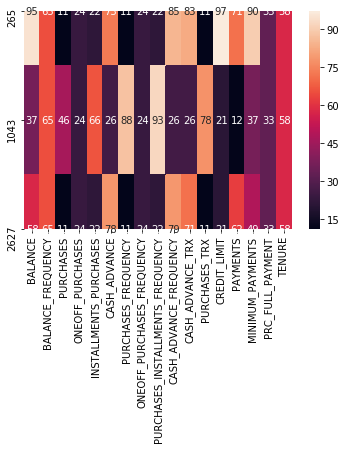

In [7]:
raw_data_without_id = raw_data.copy()
raw_data_without_id.drop(["CUST_ID"], axis=1, inplace=True)

percentiles_data = 100 * raw_data_without_id.rank(pct=True)
percentiles_samples = percentiles_data.iloc[sample_indices]
sns.heatmap(percentiles_samples, annot=True)

Generally, our sample customers do not pay cash in advance for their purchases.

**Sample 275**

Spends very little and doesn't have much balance in their card maybe due to lower credit limit. This customer could be categrorized as low-income-earner.

**Sample 5524**

This customer is a big spender with low credit limit. The customer has high balance available for spending because he/she prefers purchases in installments and regularly repays the credit issues in installments as well. So this customer can be categorized as middle-income-earner

**Sample 5533**

This customer is not a big spender but can be categorized as high-income-earner. The customer doesn't purchase in installments and regularly pays back the card issuer. This customer has very high credit limit due to their ability to repay the credit. Often than not, the bank gives high credit limit when one can show high source of income or asset value

## Feature Relevance

We will try to identify which features are relevant.

We will start by prediciting a feature using other features. The prediction score, R2, will inform us about the feature importance.

--

In [8]:
# Calculate feature-feature relavance
feature_df = cc_feature_relevance(raw_data)

In [9]:
# See feature-feature relavance
feature_df.sort_values(by="_score", ascending=False)

_predicted_feature    _score   BALANCE  BALANCE_FREQUENCY  \
6                PURCHASES_FREQUENCY  0.990537  0.000780           0.000662   
8   PURCHASES_INSTALLMENTS_FREQUENCY  0.967247  0.002446           0.000377   
2                          PURCHASES  0.935755  0.000723           0.000256   
0                            BALANCE  0.933432  0.000000           0.009265   
7         ONEOFF_PURCHASES_FREQUENCY  0.904495  0.012231           0.001480   
9             CASH_ADVANCE_FREQUENCY  0.861992  0.017145           0.005973   
3                   ONEOFF_PURCHASES  0.837964  0.002333           0.000126   
4             INSTALLMENTS_PURCHASES  0.805222  0.003197           0.000090   
13                          PAYMENTS  0.726850  0.041434           0.048756   
1                  BALANCE_FREQUENCY  0.715534  0.315832           0.000000   
11                     PURCHASES_TRX  0.706766  0.037507           0.002520   
5                       CASH_ADVANCE  0.702047  0.031435           0.012688   
16                            TENURE  0.682932  0.061703           0.292191   
15                  PRC_FULL_PAYMENT  0.662871  0.387955           0.022931   
10                  CASH_ADVANCE_TRX  0.603961  0.022103           0.014797   
12                      CREDIT_LIMIT  0.440120  0.399634           0.015877   
14                  MINIMUM_PAYMENTS  0.313313  0.342701           0.012967   

    PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
6    0.005026          0.000926                0.001887      0.000237   
8    0.002753          0.004474                0.748052      0.001070   
2    0.000000          0.816525                0.163201      0.000041   
0    0.002788          0.004659                0.003843      0.005421   
7    0.006643          0.658215                0.020375      0.002575   
9    0.004920          0.003295                0.003325      0.052192   
3    0.868571          0.000000                0.079757      0.000191   
4    0.594091          0.188452                0.000000      0.000757   
13   0.373261          0.036042                0.013449      0.234241   
1    0.023720          0.009662                0.012663      0.045988   
11   0.525134          0.031353                0.084930      0.006481   
5    0.012514          0.008215                0.008318      0.000000   
16   0.015681          0.015191                0.015787      0.027097   
15   0.088976          0.022883                0.041892      0.006992   
10   0.006055          0.010336                0.009379      0.073231   
12   0.126500          0.046966                0.032853      0.040520   
14   0.042566          0.021941                0.035341      0.042581   

    PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
6              0.000000                    0.063542   
8              0.196289                    0.023972   
2              0.000186                    0.000338   
0              0.001260                    0.002094   
7              0.183728                    0.000000   
9              0.002695                    0.003135   
3              0.000139                    0.033696   
4              0.000506                    0.002403   
13             0.007937                    0.010684   
1              0.170852                    0.008032   
11             0.139358                    0.031371   
5              0.003757                    0.008624   
16             0.030830                    0.026280   
15             0.067343                    0.014926   
10             0.004633                    0.007071   
12             0.012226                    0.020302   
14             0.006097                    0.033226   

    PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
6                           0.123097                0.000122   
8                           0.000000                0.000454   
2                           0.000940                0.000030   
0                           0.001


From the above table, we see that `PURCHASES_FREQUENCY` is the mostly predicted by the other features. However, `PURCHASES_TRX` appears to be the only relevant feature in prediciting `PURCHASES_FREQUENCY`.


## Feature Distribution

Let us look at the correlation of the features. We expect to see `PURCHASES_FREQUENCY` to be highly correlated with the other features.

--

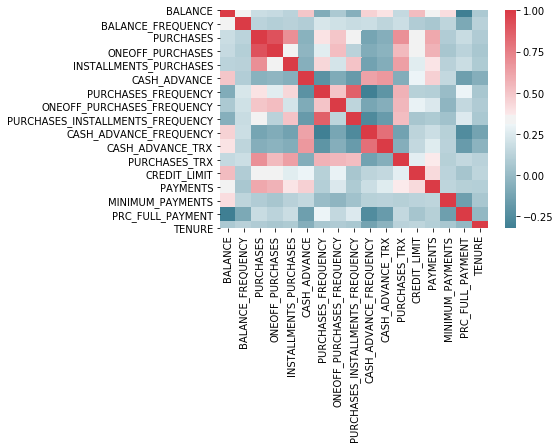

In [10]:
sns.heatmap(raw_data.corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True))

From the table above and as confirmed by the graph above, you will see that utmost 4 features are relevant in prediciting another feature. An example is seen with `CASH_ADVANCE`, `INSTALLMENTS_PURCHASES`, `ONE-OFF_PURCHASES` and `PURCHASES` being relevant in predicting `PAYMENTS`

From an early observation, we cannot use all the feautures in our solution to the problem. We will have to carry further analysis in selecting important features for clusteting. 

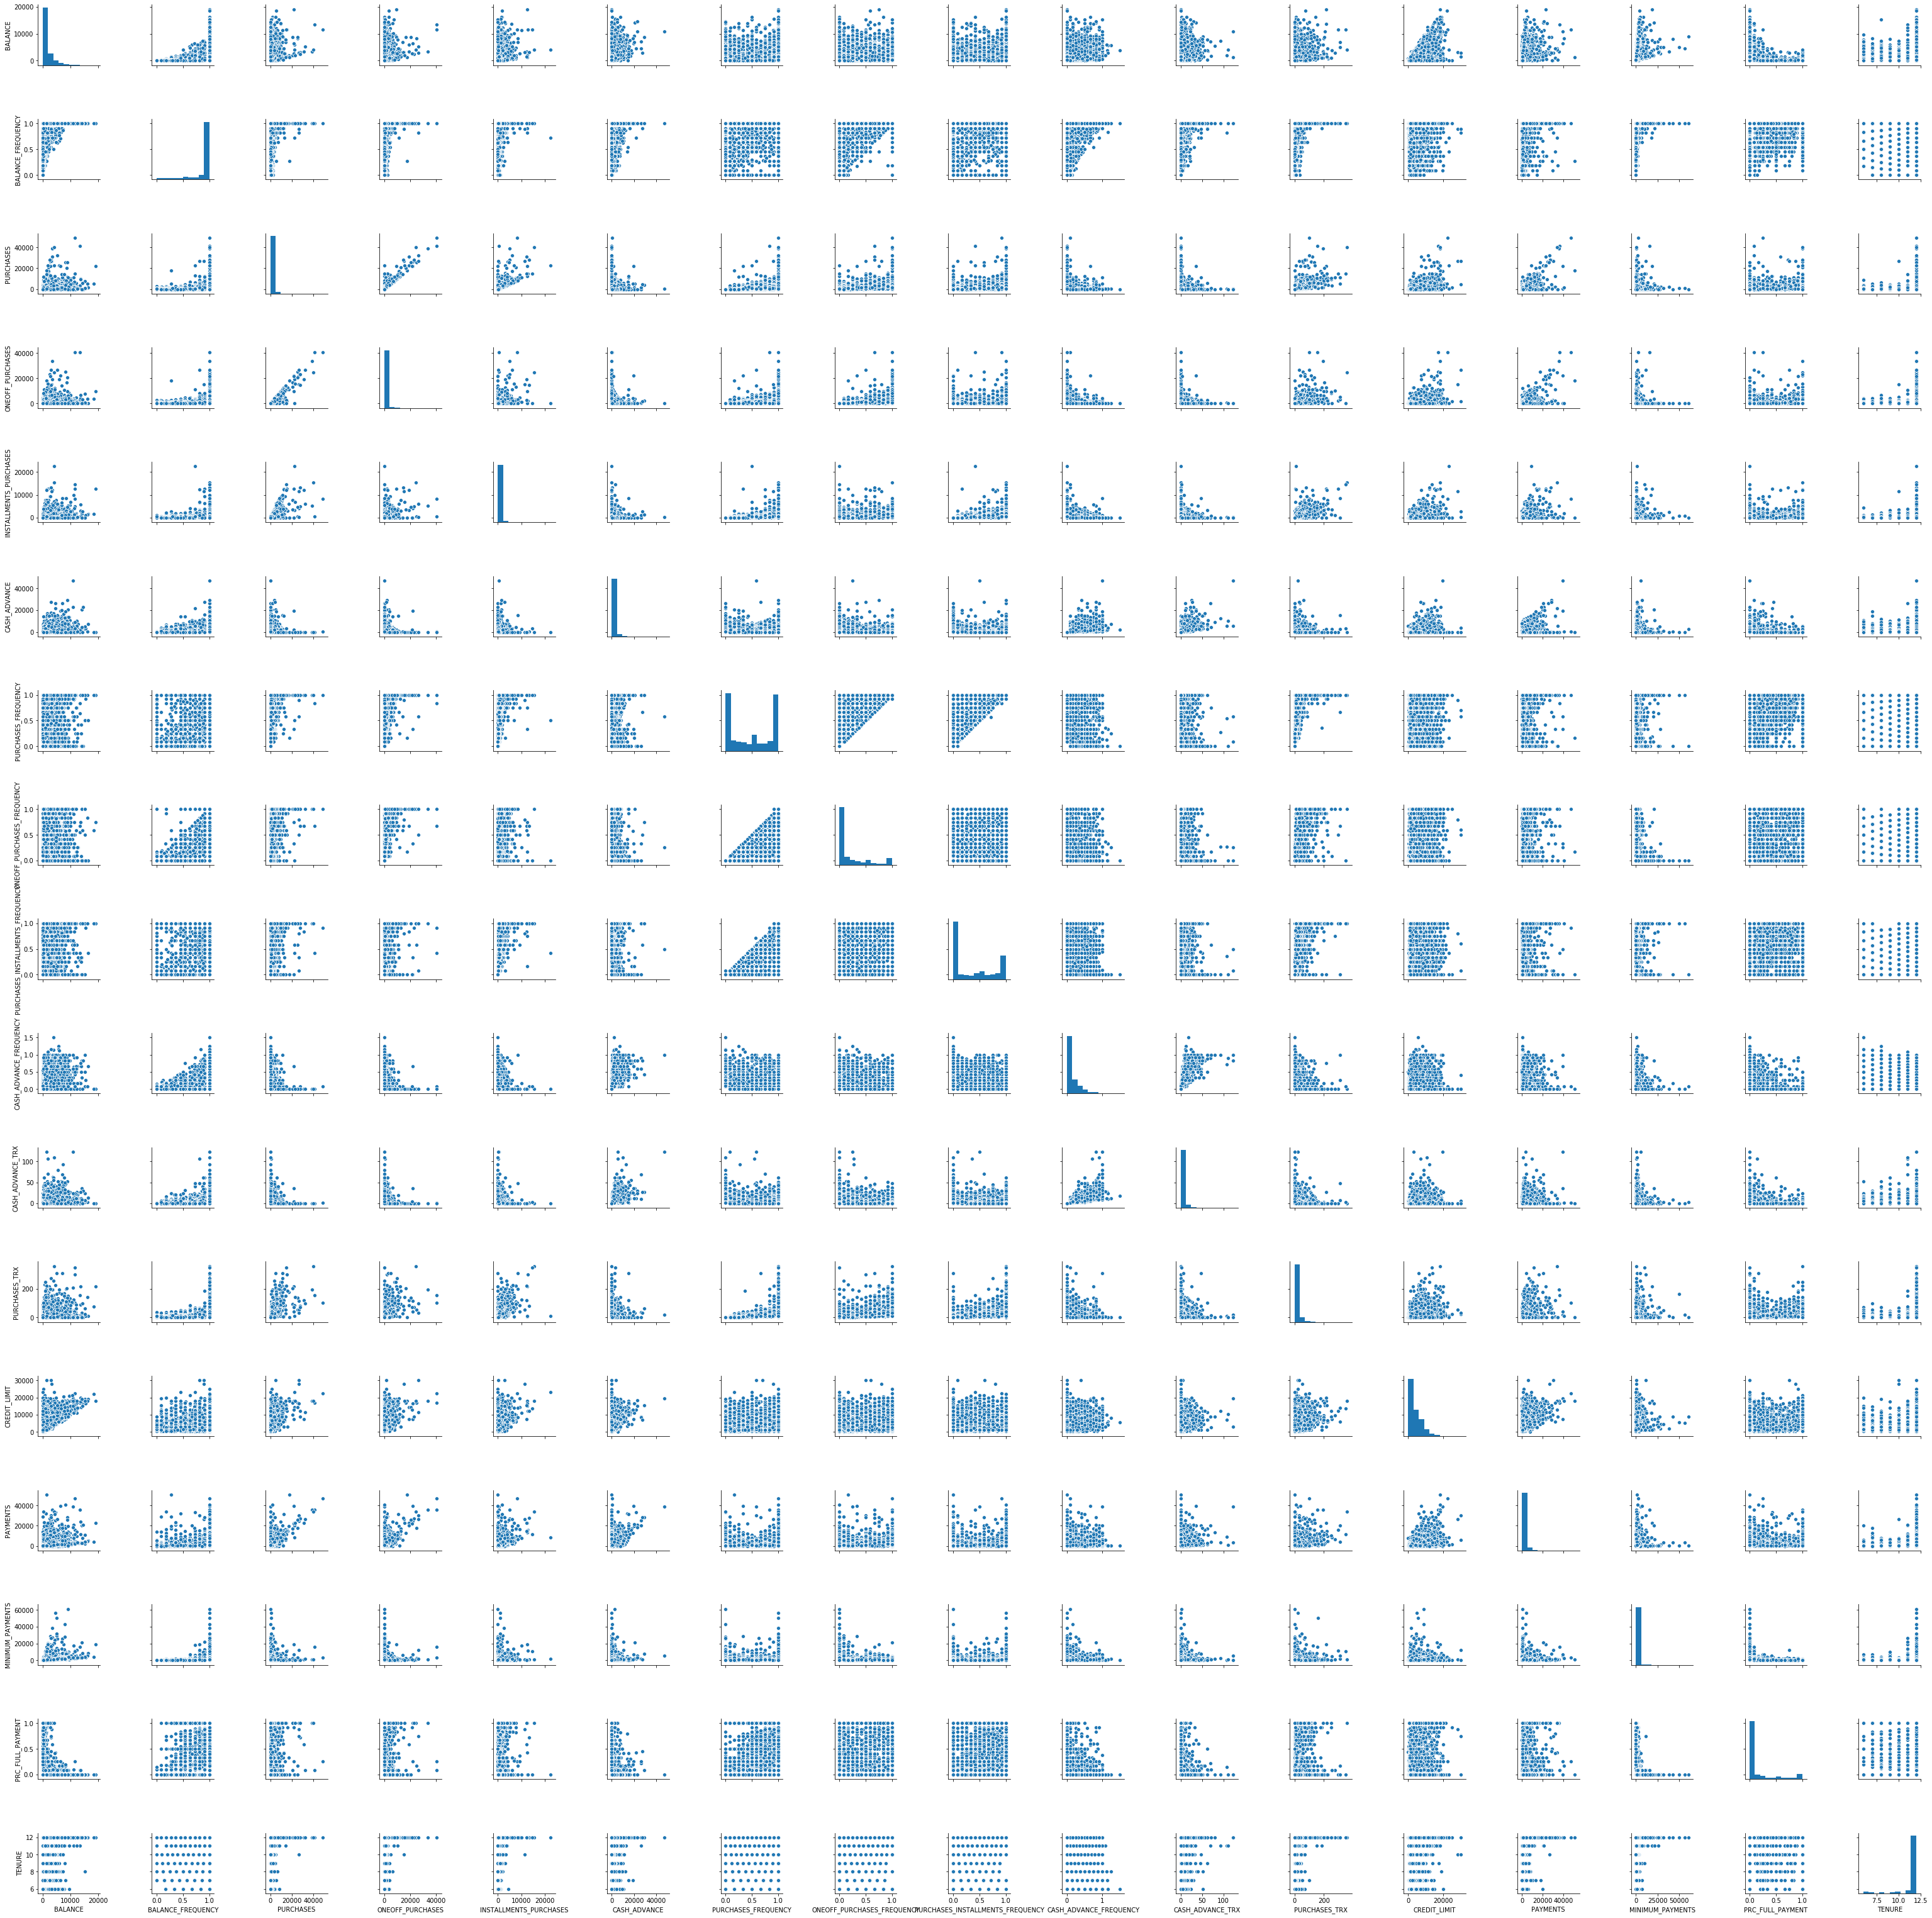

In [48]:
g = sns.pairplot(raw_data)

Concentration of data points around the origin i.e point-zero shows that the pair-feature are not correlated.

Furthermore, graphs showing evenly distributed data points all over the plot area show non-correlation between the pairs. A good example is paring `PRC_FULL_PAYMENT` with either `PURCHASES_FREQUENCY`, `ONEOFF_PURCHASES_FREQUENCY`, `PURCHASES_INSTALLMENTS_FREQUENCY`, `CASH_ADVANCE_FREQUENCY` or `TENURE`

Good examples of correlation is pairing `PURCHASES` with either `BALANCE`, `BALANCE_FREQUENCY`, `ONEOFF_PURCHASES`, `INSTALLMENTS_PURCHASES`, `PURCHASES_TRX`, `CREDIT_LIMIT` or `PAYMENTS`. You will also see that `PURCHASES` can be easily predicted by other features. The features that correlate well with `PURCHASES` have high score in feature importance.

# Data Preprocessing

The correlation above needs to be refined. A better way to do this is to scale the data and remove outliers. This will ensure that our results are significant and meaningful.

Since data is not normally distributed, i.e the mean and median vary significantly (indicating a large skew), we will apply a non-linear scaling using [Yeo-Johnson](https://academic.oup.com/biomet/article-abstract/87/4/954/232908)[1] (I.K. Yeo and R.A. Johnson, 2000) transformation that reduces skewness.

I would have used [Box-Cox](https://www.jstor.org/stable/2984418) [2] transformation but our data that has zeros. Yeo-Johnson transformation is able to transform data that zeros and negative numbers.

[1] Yeo and R.A. Johnson, “A new family of power transformations to improve normality or symmetry.” Biometrika, 87(4), pp.954-959, (2000)

[2] G.E.P. Box and D.R. Cox, “An Analysis of Transformations”, Journal of the Royal Statistical Society B, 26, 211-252 (1964)

--

In [11]:
pt = PowerTransformer(method="yeo-johnson", standardize=True)
scaled_data_ndarray = pt.fit_transform(raw_data_without_id)
scaled_data = pd.DataFrame.from_records(scaled_data_ndarray, columns=raw_data_without_id.columns)


In [12]:
scaled_data.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count  8.055000e+03       8.055000e+03  8.055000e+03      8.055000e+03   
mean  -3.881301e-17      -6.457074e-16  3.528456e-17     -5.028049e-17   
std    1.000062e+00       1.000062e+00  1.000062e+00      1.000062e+00   
min   -2.124192e+00      -2.002307e+00 -1.510734e+00     -1.002051e+00   
25%   -8.210843e-01      -6.114449e-01 -6.387413e-01     -1.002051e+00   
50%    1.535537e-01       6.268625e-01  1.614421e-01      2.388183e-01   
75%    7.205233e-01       6.268625e-01  7.062814e-01      9.908086e-01   
max    2.721945e+00       6.268625e-01  3.564315e+00      1.959567e+00   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count            8.055000e+03  8.055000e+03         8.055000e+03   
mean            -4.763415e-17 -4.145935e-17         1.764228e-17   
std              1.000062e+00  1.000062e+00         1.000062e+00   
min             -1.091958e+00 -9.385686e-01        -1.284667e+00   
25%             -1.091958e+00 -9.385686e-01        -1.026975e+00   
50%              3.599591e-01 -9.385686e-01         1.005076e-01   
75%              9.018661e-01  1.064359e+00         1.041255e+00   
max              2.225352e+00  1.723131e+00         1.213207e+00   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                8.055000e+03                      8.055000e+03   
mean                -1.464309e-16                      6.351220e-17   
std                  1.000062e+00                      1.000062e+00   
min                 -9.043461e-01                     -1.010140e+00   
25%                 -9.043461e-01                     -1.010140e+00   
50%                 -1.029840e-01                     -2.871826e-01   
75%                  1.055490e+00                      1.060756e+00   
max                  1.726098e+00                      1.373533e+00   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count            8.055000e+03      8.055000e+03   8.055000e+03  8.054000e+03   
mean             9.438619e-17      1.764228e-18   1.764228e-18  5.469785e-16   
std              1.000062e+00      1.000062e+00   1.000062e+00  1.000062e+00   
min             -8.780454e-01     -9.002991e-01  -1.393216e+00 -4.594494e+00   
25%             -8.780454e-01     -9.002991e-01  -8.824848e-01 -8.864501e-01   
50%             -8.780454e-01     -9.002991e-01   1.298593e-01 -1.354153e-01   
75%              8.426391e-01      1.057233e+00   7.164531e-01  8.230923e-01   
max              1.899706e+00      1.912907e+00   2.846245e+00  2.837447e+00   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT        TENURE  
count  8.055000e+03      7.784000e+03      8.055000e+03  8.055000e+03  
mean   1.164390e-16     -5.385666e-16     -1.354045e-16 -6.805509e-16  
std    1.000062e+00      1.000064e+00      1.000062e+00  1.000062e+00  
min   -2.816004e+00     -5.672095e+00     -6.829264e-01 -2.522137e+00  
25%   -6.067421e-01     -6.445871e-01     -6.829264e-01  4.233388e-01  
50%   -6.754940e-02     -1.224209e-01     -6.829264e-01  4.233388e-01  
75%    5.670230e-01      6.816462e-01      8.311650e-01  4.233388e-01  
max    4.518113e+00      3.869934e+00      1.864938e+00  4.233388e-01

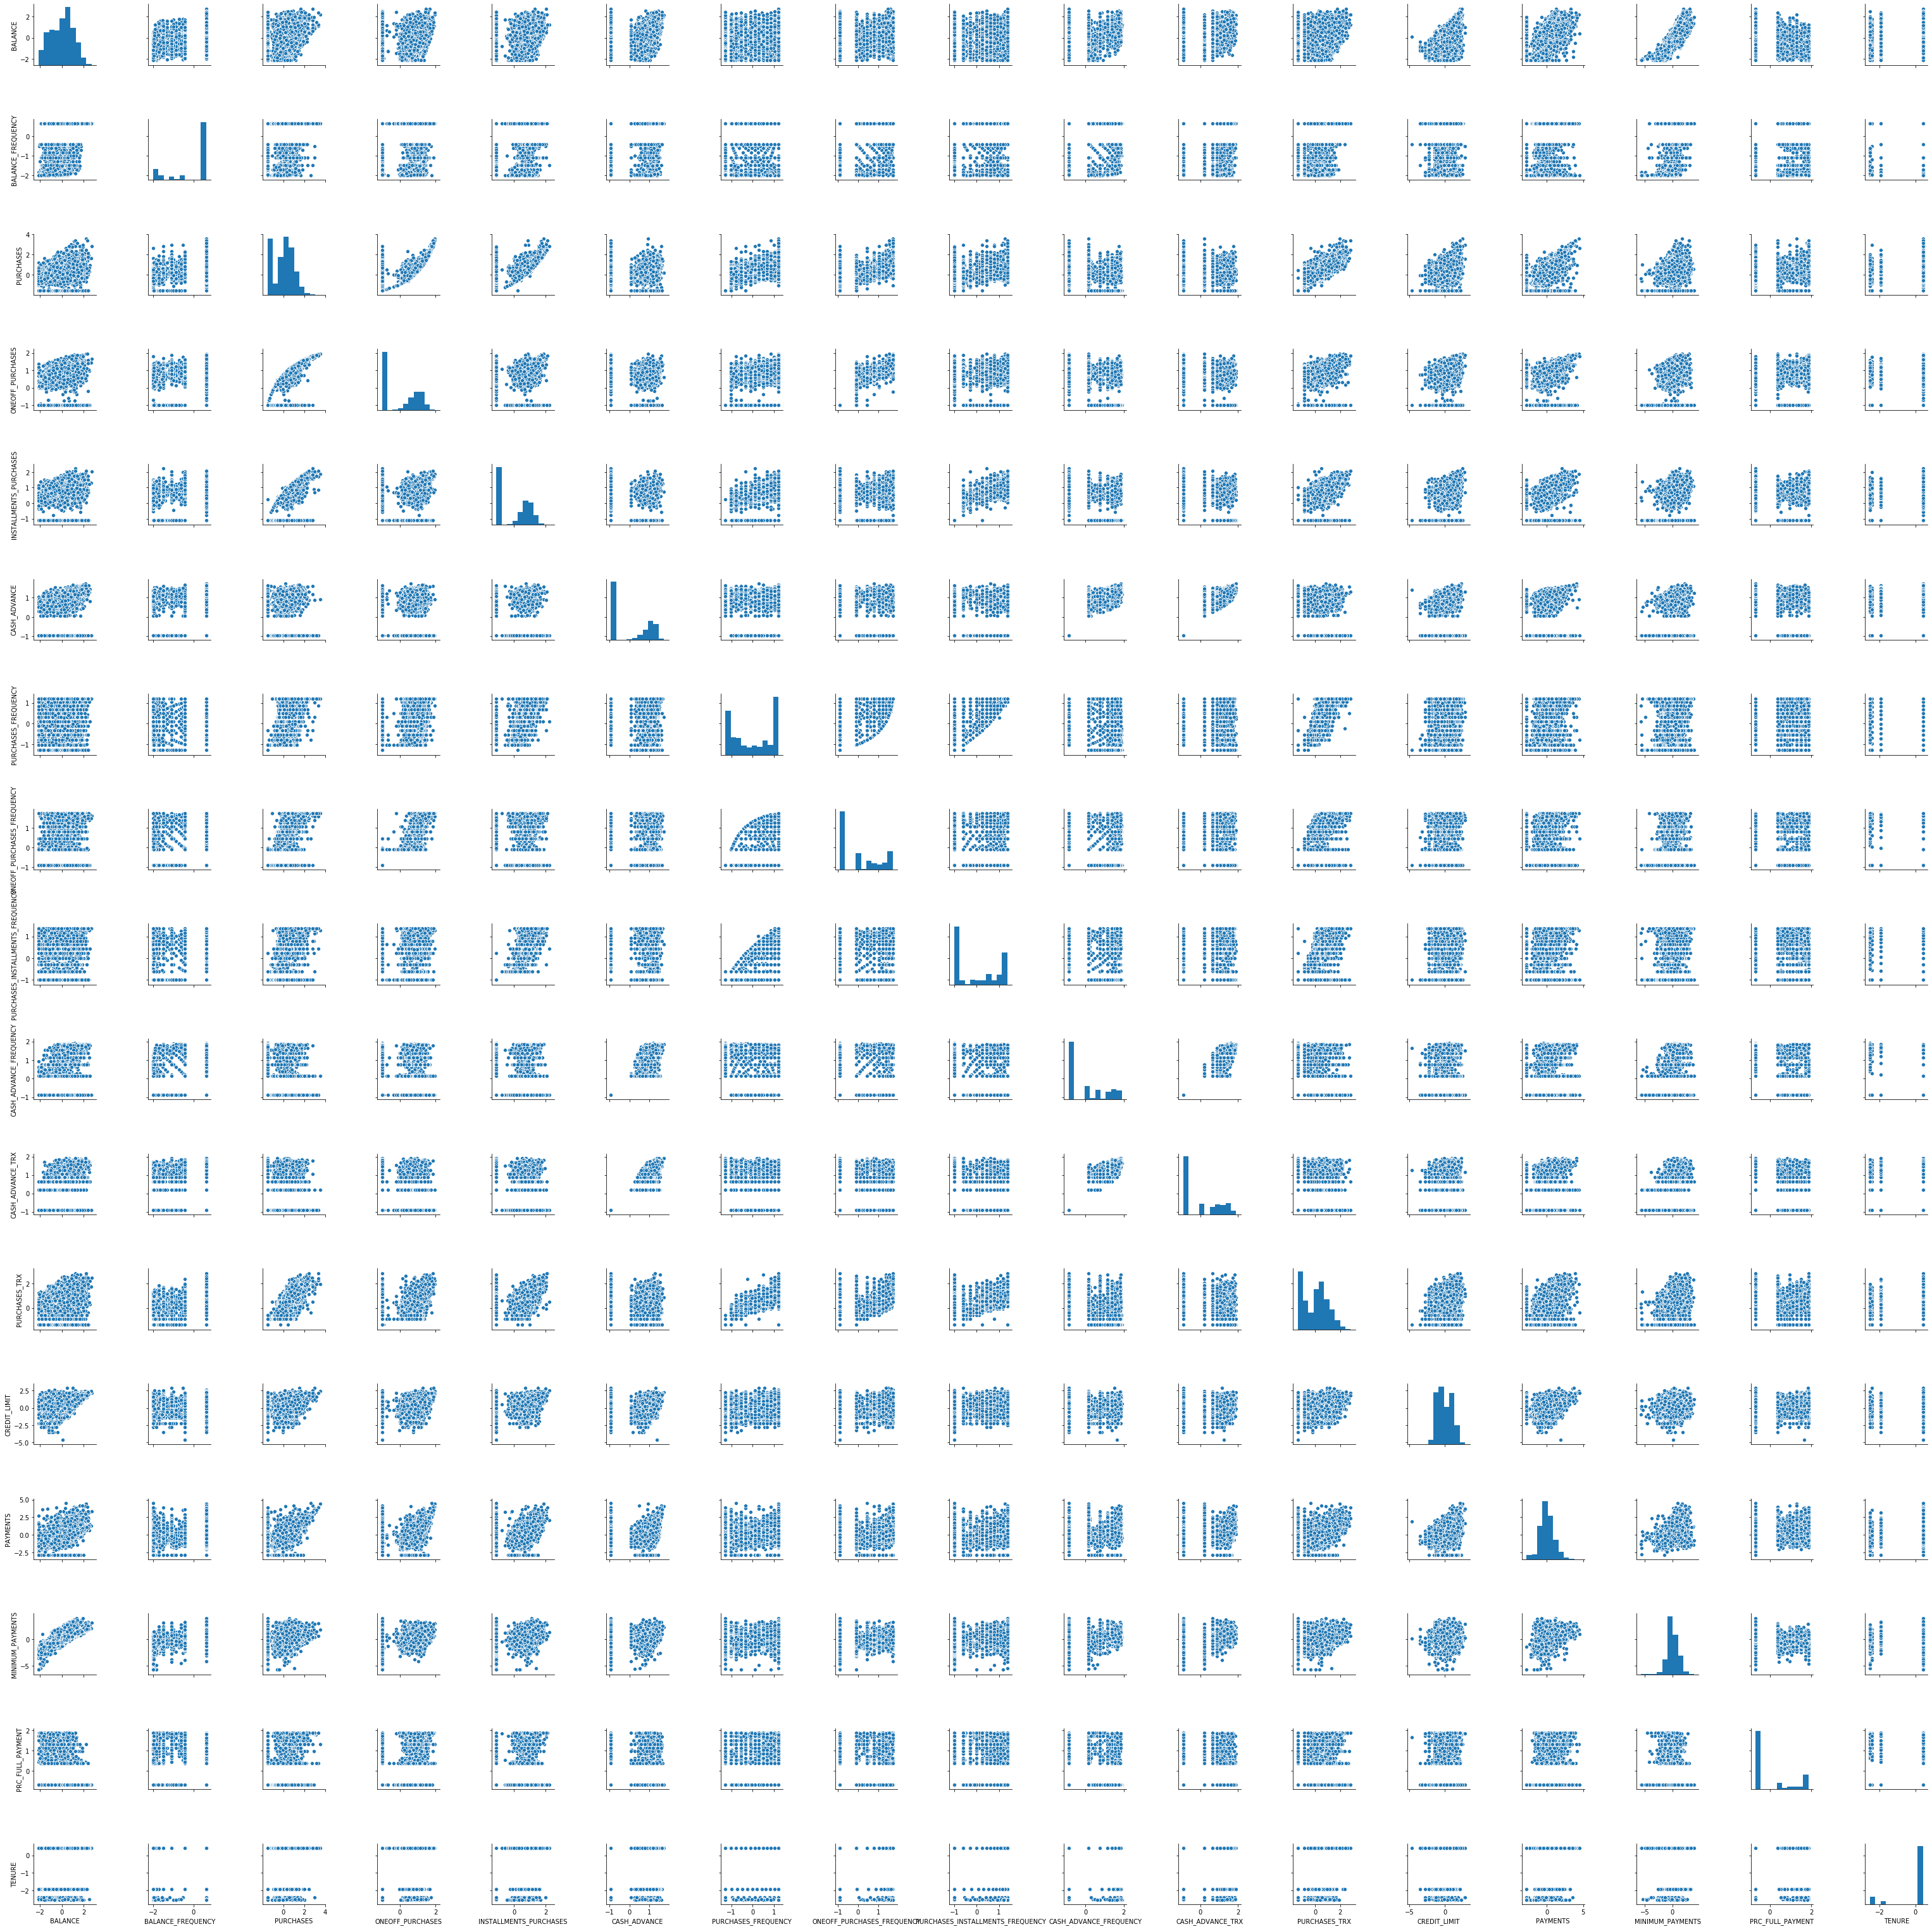

In [49]:
h = sns.pairplot(scaled_data)

In [50]:
# Lets view the scaled data of the samples
samples_scaled = pd.DataFrame(scaled_data.loc[sample_indices], columns = scaled_data.keys())
# samples_scaled.insert(0, "CUST_ID", samples["CUST_ID"])
print("\nChosen samples transaction dataset:")
display(samples_scaled)


Chosen samples transaction dataset:


BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
265   1.535712           0.626862  -1.510734         -1.002051   
1043 -0.315111           0.626862   0.088232         -1.002051   
2627  0.312548           0.626862  -1.510734         -1.002051   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
265                -1.091958      1.038068            -1.284667   
1043                0.760971     -0.938569             1.213207   
2627               -1.091958      1.112008            -1.284667   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
265                    -0.904346                         -1.010140   
1043                   -0.904346                          1.373533   
2627                   -0.904346                         -1.010140   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
265                 1.377605          1.256323      -1.393216      1.765619   
1043               -0.878045         -0.900299       0.827496     -0.962156   
2627                1.137319          0.897259      -1.393216     -0.962156   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  
265   0.460772          1.303302         -0.682926  0.423339  
1043 -0.979625         -0.487591         -0.682926  0.423339  
2627  0.233719         -0.170370         -0.682926  0.423339

## Outliers detection and removal

This forms an integral part of data pre-processing. We remove data that tend to skew the distribution of data. The presence of the data points may lead to skewed results. K-Means clustering is very sensitive to outliers. Therefore, it is important we can remove the outliers from our data if we intend to use K-Means as our benchmark model.

In [14]:
outliers_, outliers_count_ = otl.detect(scaled_data)

print("Rows that are outliers: ", len(outliers_), "\n")

print("Feature rows that are outliers:\n")
for feat, count in outliers_count_.items():
    print("\t{}: {}".format(feat, count))

Rows that are outliers:  1524 

Feature rows that are outliers:

	PURCHASES: 21
	CREDIT_LIMIT: 8055
	PAYMENTS: 356
	MINIMUM_PAYMENTS: 8055
	TENURE: 1235


In [15]:
# Check if our samples are among the outliers
for index in sample_indices:
    if index in outliers_:
        print("Index {} is an outlier".format(index))

In [16]:
# Remove outliers from our data
scaled_data_with_id = scaled_data.copy()
scaled_data_with_id.insert(0, "CUST_ID", raw_data["CUST_ID"])
outliers_df = pd.DataFrame(scaled_data.loc[outliers_], columns = scaled_data.keys())
good_data_df = scaled_data_with_id.drop(scaled_data_with_id.index[outliers_])

# I think we can disregard `CREDIT_LIMIT` and `MINIMUM_PAYMENTS` since their data points seem unrelated
good_data = good_data_df.drop(['CUST_ID','CREDIT_LIMIT', 'MINIMUM_PAYMENTS'], axis=1, inplace=False)

# Feature Transformation

We are going to transform our data into few dimensions that maximize variance. We will do this by implementing PCA

--

## PCA

Principal Component Analysis (PCA) is a method used in dimensionality reduction. Many variables are reduced into few while containing much information in them.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process (Zakaria Jaadi). [1]

[1] Zakaria Jaadi. A step by step explanation of Principal Component Analysis. Feb 28, 2019. [https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2] Accessed on Aug 1, 2019.

In [17]:
pca = PCA(n_components=good_data.shape[1])
pca.fit(good_data)

# Transform samples data using the PCA fit above
samples_scaled_2 = samples_scaled.drop(['CREDIT_LIMIT', 'MINIMUM_PAYMENTS'], axis=1)
pca_samples = pca.transform(samples_scaled_2)

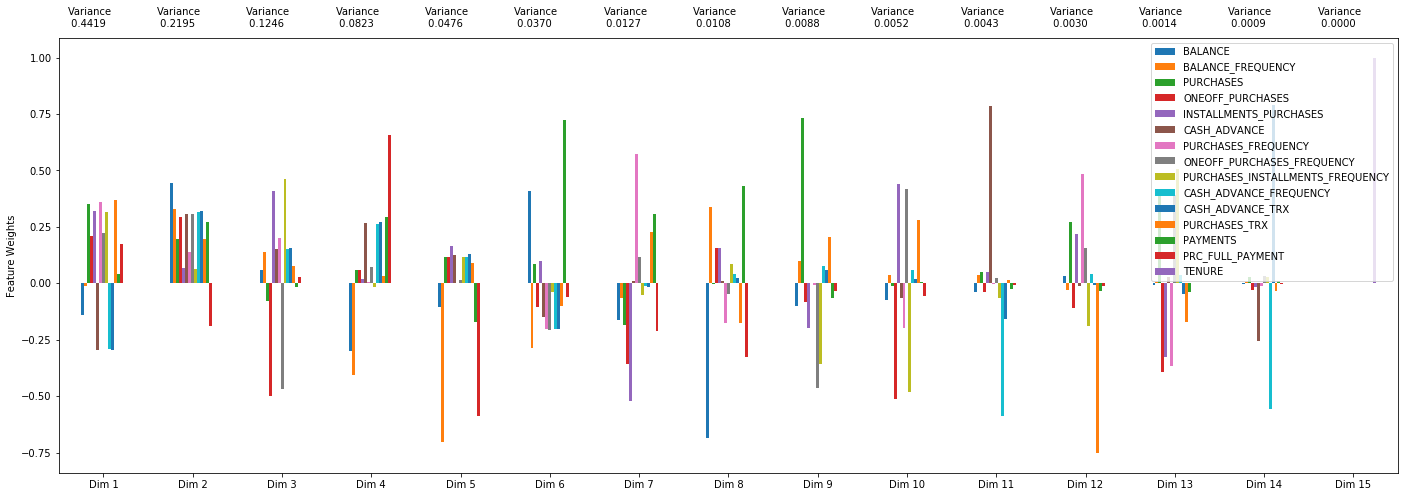

In [18]:
# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

From the above graph, we can easily pick the first 2 dimensions to represent the features.

The total variance covered by the two dimensions is about 65%. This is further shown by the figure below.

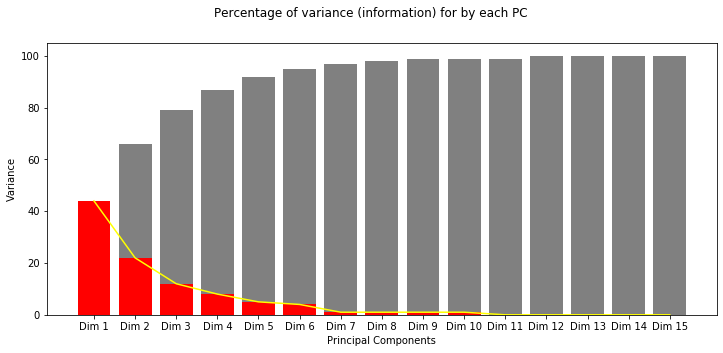

In [19]:
vs.pc_variance(pca_results)

### Observation

Lets see how our sample data will look like after PCA transformation.

In [20]:
# Display sample data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values, index=sample_indices))

Dim 1   Dim 2   Dim 3   Dim 4   Dim 5   Dim 6   Dim 7   Dim 8   Dim 9  \
265  -4.1477  0.7587  0.4670 -0.2612 -0.4726  0.5736  0.0471 -0.2613 -0.2210   
1043  1.5678 -1.0939  1.8141 -1.6627  0.1624 -0.5340  0.5122 -0.1302  0.1488   
2627 -3.8324 -0.0161  0.3179 -0.1042 -0.3695  0.0216  0.1874  0.4594 -0.1247   

      Dim 10  Dim 11  Dim 12  Dim 13  Dim 14  Dim 15  
265   0.0100 -0.2966  0.0195 -0.0054 -0.0281     0.0  
1043 -0.1378 -0.0399 -0.1287 -0.0258 -0.0079     0.0  
2627  0.0717  0.0106 -0.0226  0.0241 -0.1975     0.0

### Dimensionality Reduction

With 65% cumulative variance we are confident in using 2 dimensions in reducin the feature space. Therefore, we will generate 2 principal components from our data. We will also transform our sample data using the fitter PCA.

In [21]:
n_components=2
pca = PCA(n_components=n_components)
pca.fit(good_data)

# Transform the good data using the PCA fit above
pca_good_data = pca.transform(good_data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(
    pca_good_data,
    columns = ["Dimension {}".format(x + 1) for x in range(n_components)],
    index=good_data.index
)

In [22]:
# Display sample sample data after applying PCA transformation in two dimensions
reduced_data_sample = reduced_data.loc[sample_indices]
reduced_data_sample

Dimension 1  Dimension 2
265     -4.147725     0.758747
1043     1.567826    -1.093872
2627    -3.832400    -0.016114

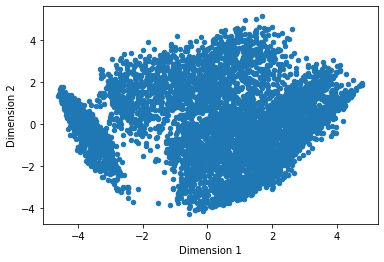

In [23]:
# Visualize reduced data
reduced_data.plot.scatter(x="Dimension 1", y="Dimension 2")

The plot above indicates that we can seperate our data into 3 clusters.

Let visualize the data using a biplot. The biplot will project original features over the components.

From the biplot you will notice that there is one cluster that spends more while another is liquid in terms of cash and balance. The cluster on the bottom-right does alot of purchasing as evidenced by huge variance in purchase related features. The cluster in the top maintains good balance in the card, pays the card issuer regularly and purchase with cash oftenly.

There is a cluster on the left that has similarities with the top one. However, for this cluster, it seems they use cash alot with less payments back to the issuer. And also seems to not be purchasing or using the credit card.

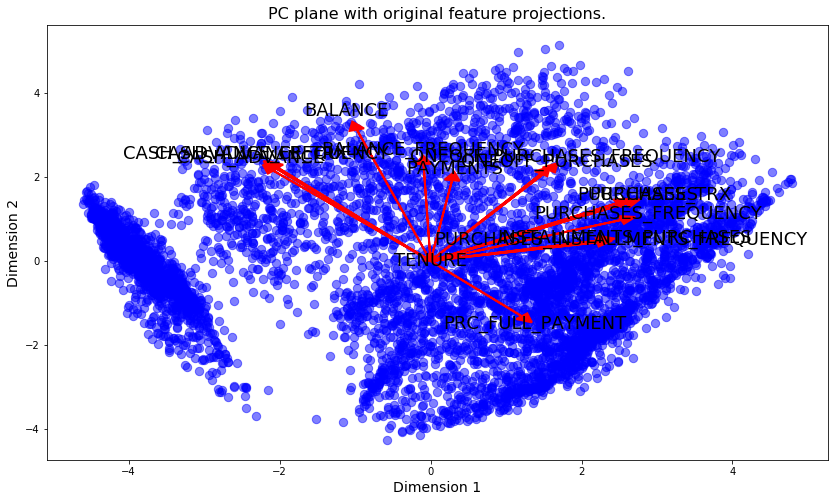

In [24]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

## Clustering

We will try and use the above insights in creating clusters that would give us acceptable score. Note that, we already biased that our data can be grouped into 3 clusters.

We will use K-Means with 3 clusters as our **benchmark model**.


In [25]:
# benchmark model
N_CLUSTER_TRIALS = range(2, 6)

def get_cluster_and_score(n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    kmeans.fit(reduced_data)
    pred = kmeans.predict(reduced_data)
    score = silhouette_score(
        reduced_data, pred)
    return score

trials = {x: get_cluster_and_score(x) for x in N_CLUSTER_TRIALS}

display(pd.DataFrame(
    data={"Cluster {}".format(x): [y] for x,y in trials.items()},
    index=["Scores"]
))

Cluster 2  Cluster 3  Cluster 4  Cluster 5
Scores   0.473172   0.452947   0.469355   0.432473

Lets look for another alogrithms that may perform better than our benchmark model and also curve out our clusters closely.

How an algorithm can scale is an important consideration.

We will carry out hard clustering since we are already interested in getting 3 clusters.

In [32]:
def get_cluster_and_score_cls(clf: tuple) -> list:
    result = []
    for algorithm in clf:
        algorithm.fit(reduced_data)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
        score = silhouette_score(reduced_data, y_pred)
        result.append(score)
    return result

def get_clfs(n_clusters: int) -> dict:
    return (
        cluster.KMeans(n_clusters, random_state=RANDOM_STATE),
        cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage="average", affinity="euclidean"),
        cluster.SpectralClustering(n_clusters=n_clusters, random_state=RANDOM_STATE)
    )

ctrials = {x: get_cluster_and_score_cls(get_clfs(x)) for x in N_CLUSTER_TRIALS}

display(pd.DataFrame(
    data={"Cluster {}".format(x): y for x,y in ctrials.items()},
    index=["K-Means", "AgglomerativeClustering", "SpectralClustering"]
))

Cluster 2  Cluster 3  Cluster 4  Cluster 5
K-Means                   0.473289   0.452947   0.469355   0.432475
AgglomerativeClustering   0.477017   0.431731   0.448804   0.406967
SpectralClustering        0.473021   0.451762   0.458073   0.436167

For n_clusters = 2 The average silhouette_score is : 0.47326310391593646
For n_clusters = 3 The average silhouette_score is : 0.452936361926468
For n_clusters = 4 The average silhouette_score is : 0.4693547727351999


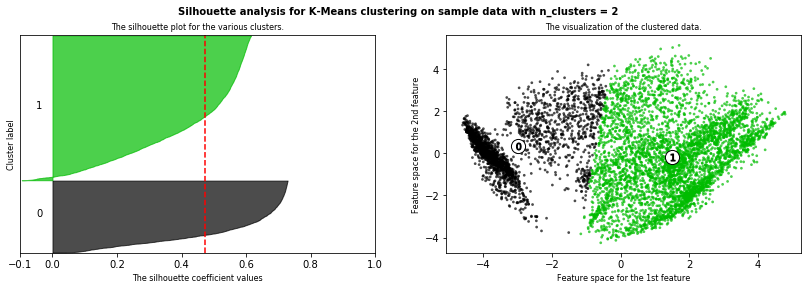

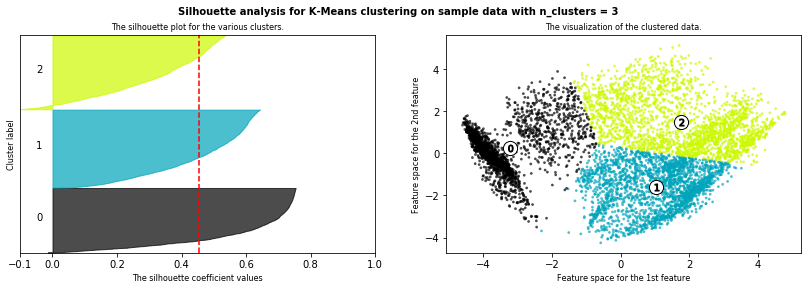

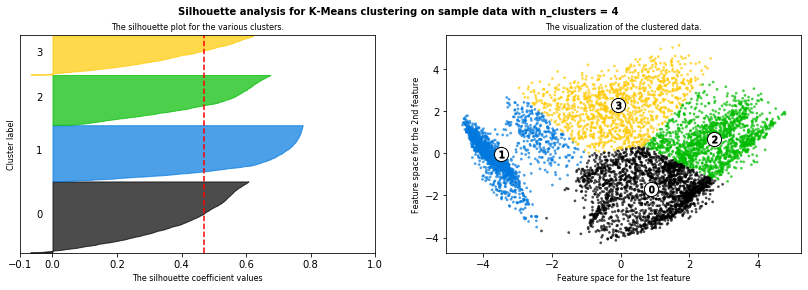

In [27]:
vs.kmeans_cluster_analysis(reduced_data, [2, 3, 4])

From the above it seems that K-Means clustering performs better than the rest.

However, looking at the above anaylsis and visualizations it seems that the obvious clusters are not defined.

Since we are interested to find 3 clusters then silhouette analysis is more ambivalent in deciding between K-Means and SpectralClsutering with 0.453 and 0.452 scores respectively.

K-Means performs better in flat geometry and with even cluster size. Therefore, we will settle for **SpectralClustering** as our algorithm of choice.

We need to optimize it such that it can fit our clusters properly.

https://towardsdatascience.com/spectral-clustering-82d3cff3d3b7

## Cluster Visualization

We will need to optimize `gamma` parameter of **SpectralClustering** algorithm in order to fit our clusters.

Score:  0.45176192126272646


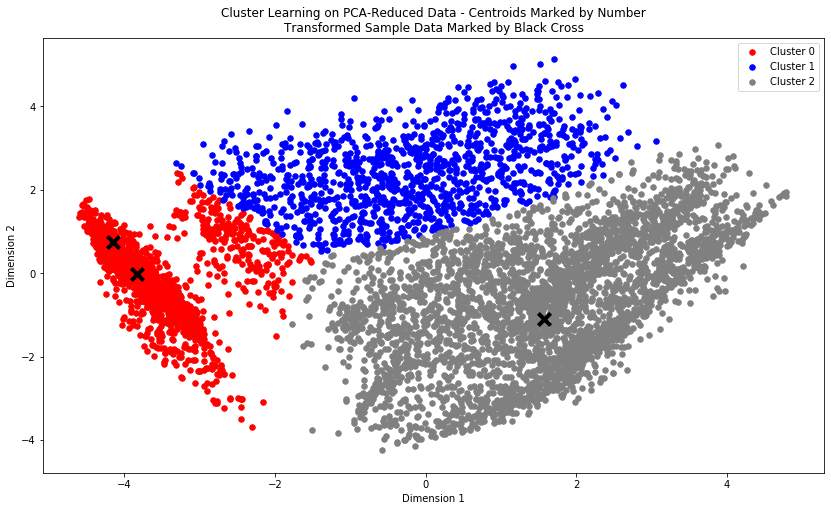

In [29]:
# # Display the results of the clustering from implementation
pre_alg = cluster.SpectralClustering(n_clusters=3, random_state=RANDOM_STATE)
pre_y_pred = pre_alg.fit_predict(reduced_data)
print("Score: ", silhouette_score(reduced_data, pre_y_pred))
vs.cluster_results(reduced_data, pre_y_pred, reduced_data_sample.to_numpy())

Score:  0.4351234999178268


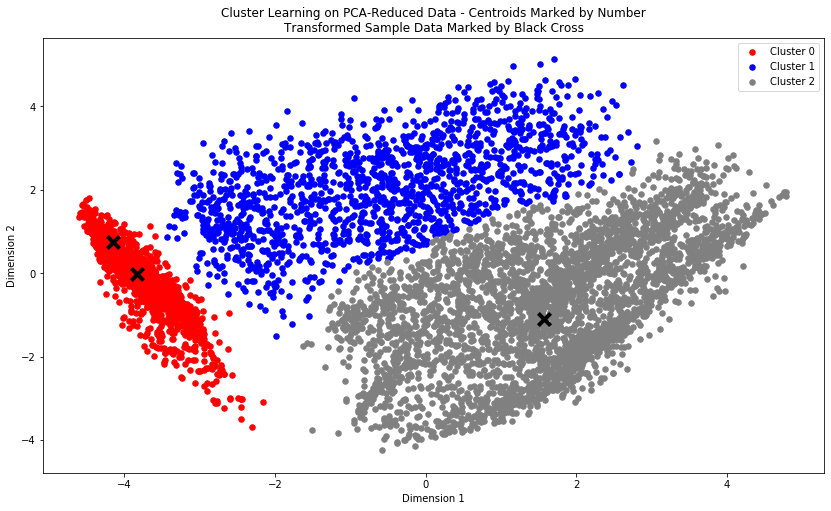

In [30]:
# # Display the results of the clustering from implementation
alg = cluster.SpectralClustering(n_clusters=3, gamma=50, random_state=RANDOM_STATE)
y_pred = alg.fit_predict(reduced_data)
print("Score: ", silhouette_score(reduced_data, y_pred))
vs.cluster_results(reduced_data, y_pred, reduced_data_sample.to_numpy())

Lets look at the cluster scores using different distance metrics [1]

[1] Pairwise Distance Metrics - https://www.mathworks.com/help/stats/classification-using-nearest-neighbors.html#bsfjytu-1
    
    

In [33]:
from sklearn.metrics import pairwise

distance_metrics = pairwise._VALID_METRICS[::]
try:
    distance_metrics.remove("minkowski")
    distance_metrics.remove("wminkowski")
except ValueError:
    pass
scores_ = {m: silhouette_score(reduced_data, y_pred, metric=m) for m in distance_metrics}

In [34]:
scores_df = pd.DataFrame(index=["Scores"], data=dict(sorted(scores_.items(), key=lambda kv: kv[1], reverse=True)))
display(scores_df)

sqeuclidean    cosine  correlation  braycurtis  chebyshev  euclidean  \
Scores     0.574856  0.520285     0.506185    0.458085   0.440063   0.435123   

              l2        l1  manhattan  cityblock  ...  hamming  jaccard  \
Scores  0.435123  0.423299   0.423299   0.423299  ...      0.0      0.0   

        kulsinski  matching  rogerstanimoto  russellrao  sokalmichener  \
Scores        0.0       0.0             0.0         0.0            0.0   

        sokalsneath  yule  haversine  
Scores          0.0   0.0  -0.013639  

[1 rows x 24 columns]

## Data Recovery

We will reconstruct our data and insert labels

In [35]:
good_data_with_label = raw_data.copy().loc[good_data_df.index]
good_data_with_label.insert(0, "Cluster", y_pred)

We have been able to create labelled data that can be used in supervised learning.

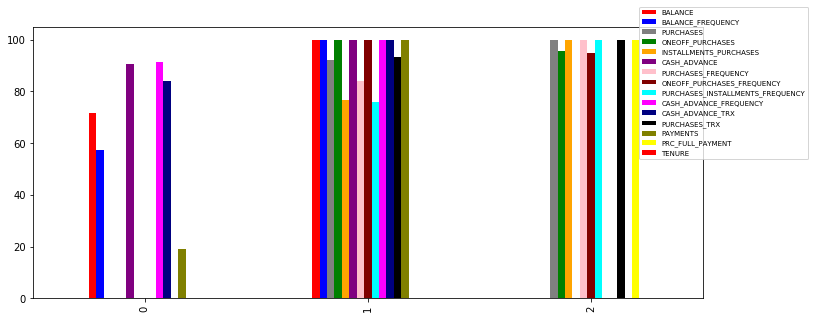

In [36]:
ax = vs.compare_cluster_means(good_data_with_label.drop(['CUST_ID'], axis=1))

The data above supports our earlier intuition that:

**Cluster 0 -> Low-Income-Earners** 
- This group will make regular repayments to ensure that they have good credit score
- Regular repayments will ensure they have relatively high balances
- This group may also be getting paid in cash and can therefore make cash-advance purchases.

**Cluster 1 -> High-Income-Earners**
- They maintain high balance in their card
- They have high purchases as well
- They are liquid financially and can therefore purchase in cash
- Due to high activity in their cards, they make regular repayments to the card issuer

**Cluster 2 -> Middle-Income-Earners**
- They prefer to purchase in cash, cash advance or in installments.
- Because of this, they will clear all their credit card dues in one full repayment.
- Therefore, you will find that their credit card has low balance and the frequency of updating their credit card balance is low

In [37]:
good_data_with_label.head()

Cluster CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  \
0        2  C15577  1039.256129           1.000000     618.75   
1        2  C17320  1536.477562           1.000000    4258.57   
2        2  C15689    30.395073           1.000000     512.47   
3        0  C17931  1120.080970           1.000000       0.00   
4        2  C10286     2.564117           0.181818      47.95   

   ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
0              0.00                  618.75      0.000000   
1           3121.93                 1136.64      0.000000   
2            512.47                    0.00      0.000000   
3              0.00                    0.00   1218.392345   
4             47.95                    0.00      0.000000   

   PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
0             0.916667                    0.000000   
1             0.916667                    0.416667   
2             1.000000                    1.000000   
3             0.000000                    0.000000   
4             0.083333                    0.083333   

   PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
0                          0.916667                    0.00                 0   
1                          0.750000                    0.00                 0   
2                          0.000000                    0.00                 0   
3                          0.000000                    0.25                 7   
4                          0.000000                    0.00                 0   

   PURCHASES_TRX  CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  \
0             11        1700.0   202.137436        262.204840   
1             30        5000.0  2660.323704        436.998853   
2             12        7000.0   484.669932        192.908611   
3              0        2500.0   299.789938        320.133269   
4              1        1500.0   294.507498         86.245988   

   PRC_FULL_PAYMENT  TENURE  
0               0.0      12  
1               0.0      12  
2               1.0      12  
3               0.0      12  
4               0.0      12

In [38]:
good_data_with_label.shape

(6531, 19)

## Prediction

We now have 6531 labelled out of 8950 unlabelled records to use for our prediction.

Predicition can be easliy done by a supervised learning technique.


### Prediction model

We have already created data that can be used for prediction. We curated this data by:
1. Identifying important features and only using them
2. Outliers detection and removal
3. Reducing feauture space though dimensionality reduction

Therefore, we shall re-use this data for building a simple prediction model.

We are not going to adress the problem of overfitting in this model.


In [39]:
# Lets build a simple models using Rand
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier

cluster_labels = y_pred # Re-using y_pred from clustering since these are our labels
features = reduced_data # Re-using PCA transformed data earlier, these are our reduced feature space
X_train, X_test, y_train, y_test = train_test_split(
    features, cluster_labels, test_size=0.20, random_state=RANDOM_STATE)

clf = DecisionTreeClassifier(random_state = RANDOM_STATE)
clf.fit(X_train, y_train)

# calculating the coefficient of determination, R2, to quantify your model's performance
print("Performace score of {:.2f}%".format(clf.score(X_test, y_test) * 100))


Performace score of 99.23%


In [40]:
def change_labels(df_: pd.DataFrame, column: str) -> pd.DataFrame:
    """Change labels according to our namings"""
    _map = {
        0: "Low-Income-Earners",
        1: "High-Income-Earners",
        2: "Middle-Income-Earners" 
    }
    df_[column] = df_[column].apply(lambda x: _map[x])
    return df_

cluster_label_name = "Group"


### New data instances

In [41]:
raw_test_data.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10015  2772.772734           1.000000       0.00              0.00   
1  C10036  1656.350781           1.000000       0.00              0.00   
2  C10038  4047.480828           1.000000    2380.55           1642.17   
3  C10041   663.447810           0.727273       0.00              0.00   
4  C10049  3910.111237           1.000000       0.00              0.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    0.00    346.811390                 0.00   
1                    0.00     99.264367                 0.00   
2                  738.38   1697.660901                 0.75   
3                    0.00   3133.063934                 0.00   
4                    0.00   1980.873201                 0.00   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                         0.0                              0.00   
1                         0.0                              0.00   
2                         0.5                              0.75   
3                         0.0                              0.00   
4                         0.0                              0.00   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.083333                 1              0        3000.0   
1                0.083333                 1              0        1800.0   
2                0.333333                 7             41        5000.0   
3                0.250000                 3              0        1800.0   
4                0.500000                 7              0        4200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   805.647974        989.962866          0.000000      12  
1   351.500199        634.569311          0.000000      12  
2  1617.894416       1541.141605          0.000000      12  
3  3067.057830        283.333445          0.166667      12  
4     0.000000               NaN          0.000000      12

### Predicting new data instances lables

In [42]:
# Reduce the diminsions by the already fitted PCA
new_data_ = raw_test_data.copy()
new_data_.drop(['CUST_ID','CREDIT_LIMIT', 'MINIMUM_PAYMENTS'], axis=1, inplace=True)
new_reduced_data = pca.transform(new_data_)

new_data_labelled = raw_test_data.copy()
y_pred_ = clf.predict(new_reduced_data)
y_pred_ = pd.to_numeric(y_pred_, downcast='integer')
new_data_labelled.insert(0, cluster_label_name, y_pred_)
change_labels(new_data_labelled, cluster_label_name)
new_data_labelled.head()

Group CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  \
0   Low-Income-Earners  C10015  2772.772734           1.000000       0.00   
1   Low-Income-Earners  C10036  1656.350781           1.000000       0.00   
2  High-Income-Earners  C10038  4047.480828           1.000000    2380.55   
3   Low-Income-Earners  C10041   663.447810           0.727273       0.00   
4   Low-Income-Earners  C10049  3910.111237           1.000000       0.00   

   ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
0              0.00                    0.00    346.811390   
1              0.00                    0.00     99.264367   
2           1642.17                  738.38   1697.660901   
3              0.00                    0.00   3133.063934   
4              0.00                    0.00   1980.873201   

   PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
0                 0.00                         0.0   
1                 0.00                         0.0   
2                 0.75                         0.5   
3                 0.00                         0.0   
4                 0.00                         0.0   

   PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
0                              0.00                0.083333                 1   
1                              0.00                0.083333                 1   
2                              0.75                0.333333                 7   
3                              0.00                0.250000                 3   
4                              0.00                0.500000                 7   

   PURCHASES_TRX  CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  \
0              0        3000.0   805.647974        989.962866   
1              0        1800.0   351.500199        634.569311   
2             41        5000.0  1617.894416       1541.141605   
3              0        1800.0  3067.057830        283.333445   
4              0        4200.0     0.000000               NaN   

   PRC_FULL_PAYMENT  TENURE  
0          0.000000      12  
1          0.000000      12  
2          0.000000      12  
3          0.166667      12  
4          0.000000      12

### Predicting our samples cluster

In visualizing our clusters

In [43]:
# Our Samples
raw_data.loc[sample_indices]

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
265   C11411  5745.789490                1.0       0.00               0.0   
1043  C17776   378.320894                1.0     315.02               0.0   
2627  C15038  1129.185643                1.0       0.00               0.0   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
265                     0.00    965.726556                  0.0   
1043                  315.02      0.000000                  1.0   
2627                    0.00   1385.126221                  0.0   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
265                          0.0                               0.0   
1043                         0.0                               1.0   
2627                         0.0                               0.0   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
265                 0.333333                 6              0       13500.0   
1043                0.000000                 0             20        1500.0   
2627                0.250000                 3              0        1500.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
265   1684.800793       1779.683281               0.0      12  
1043   206.090316        202.391607               0.0      12  
2627  1275.071841        293.203915               0.0      12

In [44]:
# Let see how our samples were clusteres
s_ = good_data_with_label.copy().loc[sample_indices]
change_labels(s_, "Cluster")
s_

Cluster CUST_ID      BALANCE  BALANCE_FREQUENCY  \
265      Low-Income-Earners  C11411  5745.789490                1.0   
1043  Middle-Income-Earners  C17776   378.320894                1.0   
2627     Low-Income-Earners  C15038  1129.185643                1.0   

      PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
265        0.00               0.0                    0.00    965.726556   
1043     315.02               0.0                  315.02      0.000000   
2627       0.00               0.0                    0.00   1385.126221   

      PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
265                   0.0                         0.0   
1043                  1.0                         0.0   
2627                  0.0                         0.0   

      PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
265                                0.0                0.333333   
1043                               1.0                0.000000   
2627                               0.0                0.250000   

      CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT     PAYMENTS  \
265                  6              0       13500.0  1684.800793   
1043                 0             20        1500.0   206.090316   
2627                 3              0        1500.0  1275.071841   

      MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
265        1779.683281               0.0      12  
1043        202.391607               0.0      12  
2627        293.203915               0.0      12

In [45]:
samples_tranformed_data = good_data.copy().loc[sample_indices]
samples_tranformed_data

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
265   1.535712           0.626862  -1.510734         -1.002051   
1043 -0.315111           0.626862   0.088232         -1.002051   
2627  0.312548           0.626862  -1.510734         -1.002051   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
265                -1.091958      1.038068            -1.284667   
1043                0.760971     -0.938569             1.213207   
2627               -1.091958      1.112008            -1.284667   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
265                    -0.904346                         -1.010140   
1043                   -0.904346                          1.373533   
2627                   -0.904346                         -1.010140   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  PAYMENTS  \
265                 1.377605          1.256323      -1.393216  0.460772   
1043               -0.878045         -0.900299       0.827496 -0.979625   
2627                1.137319          0.897259      -1.393216  0.233719   

      PRC_FULL_PAYMENT    TENURE  
265          -0.682926  0.423339  
1043         -0.682926  0.423339  
2627         -0.682926  0.423339

In [47]:
pca_samples_tranformed_data = pca.transform(samples_tranformed_data)

samples_ = raw_data.copy().loc[sample_indices]

y_pred_samples = clf.predict(pca_samples_tranformed_data)
y_pred_samples = pd.to_numeric(y_pred_samples, downcast='integer')
samples_.insert(0, cluster_label_name, y_pred_samples)
samples_ = change_labels(samples_, cluster_label_name)
samples_.head()

Group CUST_ID      BALANCE  BALANCE_FREQUENCY  \
265      Low-Income-Earners  C11411  5745.789490                1.0   
1043  Middle-Income-Earners  C17776   378.320894                1.0   
2627     Low-Income-Earners  C15038  1129.185643                1.0   

      PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
265        0.00               0.0                    0.00    965.726556   
1043     315.02               0.0                  315.02      0.000000   
2627       0.00               0.0                    0.00   1385.126221   

      PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
265                   0.0                         0.0   
1043                  1.0                         0.0   
2627                  0.0                         0.0   

      PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
265                                0.0                0.333333   
1043                               1.0                0.000000   
2627                               0.0                0.250000   

      CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT     PAYMENTS  \
265                  6              0       13500.0  1684.800793   
1043                 0             20        1500.0   206.090316   
2627                 3              0        1500.0  1275.071841   

      MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
265        1779.683281               0.0      12  
1043        202.391607               0.0      12  
2627        293.203915               0.0      12